# Simple Ising model example

We start by defining a graph, and simulating a temperature range

In [1]:
import networkx as nx
from Toolbox import infcy # montecarlo methods
from Models import fastIsing # models

import numpy as np

# graph = nx.path_graph(5, nx.DiGraph())


graph = nx.empty_graph()
graph.add_node(1); graph.add_node(0)
# graph = nx.path_graph(5, nx.DiGraph())
# graph.add_edge(0, 5)
# graph.add_edge(0,0)
# graph.add_edge(5, 6)
# graph.add_edge(0,0)
# graph = nx.barabasi_albert_graph(200, 3)
model = fastIsing.Ising(graph)

In [2]:
# match magnetization over temp range
temps        = np.linspace(0, graph.number_of_nodes() // 2, 100)
nSamples     = int(1e3)

model.magSide    = '' # equal magnetization sampling
model.updateType = 'single' # ultra smooth when single


mag, sus = model.matchMagnetization(temps, nSamples)
sus[np.isfinite(sus) == 0] = 0 # remove nans
idx     = np.argsort(sus)[-3] # get 'max' idx ; second is used
model.t = temps[idx]


100%|██████████| 100/100 [00:00<00:00, 721.15it/s]

Computing mag per t


In [3]:
deltas        = 50             #conditional time steps
nSamples      = 1000       # max number of states
step          = int(1e3)   
burninSamples = 100            # burninSamples + step = sim. steps until sample
repeats       = int(1e4)       # number of conditional repeats

reverse = False
# reverse = True
if reverse:
    res = np.zeros((nSamples, model.nNodes))
    rngs= np.random.randint(0, model.nNodes, size = nSamples)
    for i in range(nSamples):
        res[i] = model.updateState(rngs[[i]])
    nWindow = deltas
    ps = {}
    px = np.zeros((nWindow, model.nNodes, model.nStates))
    cpx= {}
    Z  = (nSamples - 1 - nWindow) 

    statemapper = {i : idx for idx, i in enumerate([-1, 1])}

    c = 0
    for i in range(nWindow, nSamples - 1):
        tmp   = res[i-nWindow : i]
        state = tuple(tmp[-1])
        c += 1
        ps[state] = ps.get(state, 0) + 1
        if state not in cpx:
            cpx[state] = np.zeros(( nWindow, model.nNodes, model.nStates))
        for t, stateAtTime in enumerate(tmp):
            for node, nodeState in enumerate(stateAtTime):
                px[t, node,   statemapper[nodeState]] += 1 / Z
                cpx[state][t, node, statemapper[nodeState]] += 1 
    c = 0
    mi = np.zeros((nWindow, model.nNodes))
    for state, val in ps.items():
        cpx[state] /= val
        mi += np.nansum(cpx[state] * np.log2(cpx[state]), axis = -1) * val / Z
    mi -= np.nansum(px * np.log2(px), axis = -1)
else:
    snapshots   = infcy.getSnapShots(model, nSamples, step, burninSamples)
    cpx = infcy.monteCarlo(model, snapshots,\
                          deltas, repeats)
    px, mi = infcy.mutualInformation(cpx, deltas, snapshots, model)


100%|██████████| 4/4 [00:00<00:00, 23.65it/s]

done
Found 4 states
Delta =  0.12 sec
Decoding..
starting runs
Delta =  0.18 sec



/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log2
/home/casper/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in multiply


/home/casper/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


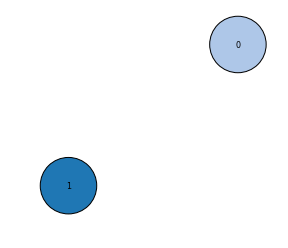

In [8]:
# Plotting
# The graph
from matplotlib.pyplot import *
from Utils import plotting as plotz # plotting toolbox
positions   = {}
for node, pos in  nx.nx_agraph.graphviz_layout(model.graph, prog = 'neato').items():
    positions[node] =  np.array(pos) * .1

fig, ax = subplots()
p = dict(layout = dict(scale = 1),\
         circle = dict(\
                     radius = 1),\
         annotate = dict(fontsize = 10)
         )
plotz.addGraphPretty(model.graph, ax,  positions, mapping = model.mapping, **p)
ax.axis('off')
fig.show()
show()

## Magnetization and susceptibilty
Let's draw some plots. First we start with the magnetization as function of temperature. Additionally, we plot the susceptibility. 


/home/casper/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


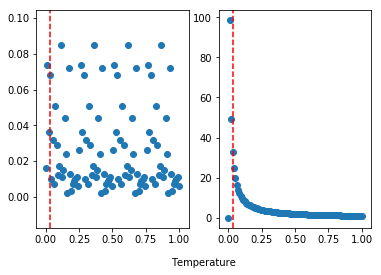

In [5]:
# show mag and sus as function of temperature
fig, ax = subplots(1, 2)
ax[0].scatter(temps, mag, label = 'Magnetization')
ax[1].scatter(temps, sus, label = 'Susceptebility')
ax[0].axvline(temps[idx], color = 'red', linestyle = 'dashed')
ax[1].axvline(temps[idx], color = 'red', linestyle = 'dashed')
mainax = fig.add_subplot(111, frameon = False, \
                         xticks = [],\
                         yticks = [], \
                        )
mainax.set_xlabel('Temperature', labelpad = 30)
fig.show()

# Mutual information decay


/home/casper/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


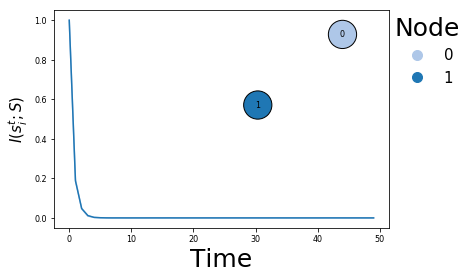

In [9]:
# show mi
# %matplotlib qt5
from mpl_toolkits.axes_grid.inset_locator import inset_axes

cmap = cm.tab20 if model.nNodes <20 else cm.nipy_spectral# colors per node
colors= cmap(np.arange(model.nNodes))
rcParams['axes.prop_cycle'] = cycler('color', colors)

x = np.arange(-mi.shape[0], 0) if reverse else np.arange(mi.shape[0])
fig, ax = subplots()
elements = []

inax = inset_axes(ax,
                    width  ="50%", 
                    height ="50%",
                    loc    = 'upper right')
plotz.addGraphPretty(graph, ax = inax, cmap = colors,mapping = model.mapping, positions = positions, **p)
inax.axis('off')

for node, label in sorted(model.rmapping.items(), key = lambda x: x[1]):
    ax.plot(x, mi[:, node], color = colors[node])
    element = Line2D(\
                     [0], [0], marker = '.', label = label, \
                     linestyle  = 'none', color = colors[node],\
                     markersize = 20)
    
    elements.append(element)
ax.set_xlabel('Time', fontsize = 25)
ax.set_ylabel('$I(s_i^t ; S)$', fontsize = 15)

ax.legend(handles = elements, title = 'Node', \
          title_fontsize = 25, fontsize = 15, \
          bbox_to_anchor = (1, 1), \
          loc = 'upper left',\
          borderaxespad = 0, frameon = False)
ax.tick_params(labelsize = 8)
fig.show()
# fig.savefig('../thesis/presentation/figures/simple_example_time.eps', bbox_inches = "tight")
# fig.subplots_adjust(right = 1.2)
# fig.tight_layout()
# fig.show()
# tmp = np.trapz(mi, np.arange(mi.shape[0]), axis = 0)
# degs= dict(model.graph.degree())
# fig, ax = subplots()
# for node, idx in model.mapping.items():
#     ax.scatter(degs[node], tmp[idx], color = colors[idx])
# ax.set(xlabel = 'degree', ylabel = '$\mu_i$')
# fig.show()
# print(model.rmapping, model.mapping)